In [1]:
#import machine learning libraries, sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

In [2]:
data_train = np.load("Embeddings/ptbdb_train_embeddings.npz")
data_test = np.load("Embeddings/ptbdb_test_embeddings.npz")

X_train = data_train["embeddings"]
y_train = data_train["labels"]
X_test = data_test["embeddings"]
y_test = data_test["labels"]

## Train OG Machine Learning classifiers directly on the data

In [3]:
#Train random forest and MLP classifiers on data and evaluate ROC-AUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#train random forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

#train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100))
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100))

In [4]:
#Also train kNN and naive bayes classifiers for baseline comparison
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#train kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#train naive bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

Accuracy RF: 93.71%
Accuracy MLP: 96.60%
Accuracy KNN: 92.96%
Accuracy NB: 62.71%


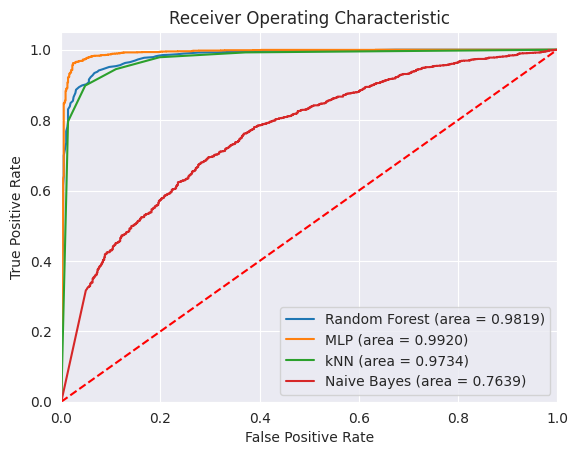

In [5]:
#predict probabilities for each classifier
y_pred_rf = rf.predict_proba(X_test)
y_pred_mlp = mlp.predict_proba(X_test)
y_pred_knn = knn.predict_proba(X_test)
y_pred_nb = nb.predict_proba(X_test)

acc_rf = metrics.accuracy_score(y_test, np.argmax(y_pred_rf, axis=1))
acc_mlp = metrics.accuracy_score(y_test, np.argmax(y_pred_mlp, axis=1))
acc_knn = metrics.accuracy_score(y_test, np.argmax(y_pred_knn, axis=1))
acc_nb = metrics.accuracy_score(y_test, np.argmax(y_pred_nb, axis=1))

print("Accuracy RF: {:.2f}%".format(acc_rf*100))
print("Accuracy MLP: {:.2f}%".format(acc_mlp*100))
print("Accuracy KNN: {:.2f}%".format(acc_knn*100))
print("Accuracy NB: {:.2f}%".format(acc_nb*100))

#calculate ROC-AUC for each classifier
roc_auc_rf = metrics.roc_auc_score(y_test, y_pred_rf[:, 1])
roc_auc_mlp = metrics.roc_auc_score(y_test, y_pred_mlp[:, 1])
roc_auc_knn = metrics.roc_auc_score(y_test, y_pred_knn[:, 1])
roc_auc_nb = metrics.roc_auc_score(y_test, y_pred_nb[:, 1])

#Calculate ROC curves for each classifier
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf[:, 1])
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test, y_pred_mlp[:, 1])
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, y_pred_knn[:, 1])
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test, y_pred_nb[:, 1])

#plot ROC curves
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.4f)' % roc_auc_rf)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = %0.4f)' % roc_auc_mlp)
plt.plot(fpr_knn, tpr_knn, label='kNN (area = %0.4f)' % roc_auc_knn)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.4f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

# calculate confusion matrices
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
cm_mlp = confusion_matrix(y_test, mlp.predict(X_test))
cm_knn = confusion_matrix(y_test, knn.predict(X_test))
cm_nb = confusion_matrix(y_test, nb.predict(X_test))

print("Confusion matrices:")
print("Random Forest")
print(cm_rf)
print("MLP")
print(cm_mlp)
print("KNN")
print(cm_knn)
print("Naive Bayes")
print(cm_nb)

#Calculate F1 score
f1_rf = metrics.f1_score(y_test, rf.predict(X_test))
f1_mlp = metrics.f1_score(y_test, mlp.predict(X_test))
f1_knn = metrics.f1_score(y_test, knn.predict(X_test))
f1_nb = metrics.f1_score(y_test, nb.predict(X_test))

print("F1 scores:")
print("Random Forest: ", f1_rf)
print("MLP: ", f1_mlp)
print("kNN: ", f1_knn)
print("Naive Bayes: ", f1_nb)



Confusion matrices:
Random Forest
[[ 685  123]
 [  55 2047]]
MLP
[[ 759   49]
 [  34 2068]]
KNN
[[ 736   72]
 [ 125 1977]]
Naive Bayes
[[ 621  187]
 [ 906 1196]]
F1 scores:
Random Forest:  0.9583333333333334
MLP:  0.9803270917278977
kNN:  0.9525415562515057
Naive Bayes:  0.6863701578192253


## Feature Engineering

In [6]:
df_train = pd.read_csv('ptbdb_train.csv', header=None)

#Separate labels from timeseries
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

melted_df = X_train.melt(var_name='time', value_name='values')

# Add an 'id' column to indicate the time series number
melted_df['id'] = melted_df.groupby('time').cumcount()

# Reorder columns
timeseries = melted_df[['id', 'time', 'values']]
timeseries


,id,time,values
0,0,0,1.000000
1,1,0,1.000000
2,2,0,0.975917
3,3,0,0.952505
4,4,0,0.994152
...,...,...,...
2176862,11636,186,0.000000
2176863,11637,186,0.000000
2176864,11638,186,0.000000
2176865,11639,186,0.000000


In [14]:
y = pd.DataFrame({'id': range(len(y_train)), 'lbl': y_train})
y_series = y['lbl']
y_series

0        1.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
11636    1.0
11637    1.0
11638    1.0
11639    1.0
11640    1.0
Name: lbl, Length: 11641, dtype: float64

In [10]:
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 40/40 [18:04<00:00, 27.10s/it]  


<function tsfresh.feature_extraction.extraction.extract_features(timeseries_container, default_fc_parameters=None, kind_to_fc_parameters=None, column_id=None, column_sort=None, column_kind=None, column_value=None, chunksize=None, n_jobs=8, show_warnings=False, disable_progressbar=False, impute_function=None, profile=False, profiling_filename='profile.txt', profiling_sorting='cumulative', distributor=None, pivot=True)>

In [12]:
extracted_features

,values__variance_larger_than_standard_deviation,values__has_duplicate_max,values__has_duplicate_min,values__has_duplicate,values__sum_values,values__abs_energy,values__mean_abs_change,values__mean_change,values__mean_second_derivative_central,values__median,...,values__fourier_entropy__bins_5,values__fourier_entropy__bins_10,values__fourier_entropy__bins_100,values__permutation_entropy__dimension_3__tau_1,values__permutation_entropy__dimension_4__tau_1,values__permutation_entropy__dimension_5__tau_1,values__permutation_entropy__dimension_6__tau_1,values__permutation_entropy__dimension_7__tau_1,values__query_similarity_count__query_None__threshold_0.0,values__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,1.0,1.0,31.761560,8.927965,0.014062,-0.005376,0.000728,0.178528,...,0.161651,0.316683,0.974941,1.566183,2.558113,3.418415,3.910249,4.101044,NaN,0.602734
1,0.0,0.0,1.0,1.0,21.162685,7.935466,0.032056,-0.005376,0.002291,0.000000,...,0.117714,0.176399,1.274168,1.105742,1.719584,2.258974,2.581583,2.731673,NaN,0.669755
2,0.0,0.0,1.0,1.0,18.361812,5.907348,0.022110,-0.005247,0.000764,0.071674,...,0.853715,1.276388,2.616993,1.230186,1.766055,2.281631,2.684533,2.957541,NaN,0.692661
3,0.0,0.0,1.0,1.0,17.381913,5.044730,0.023695,-0.005121,0.000986,0.069616,...,0.381096,0.862994,2.195313,1.524769,2.514057,3.325593,3.828358,4.140207,NaN,0.642160
4,0.0,0.0,1.0,1.0,54.557505,22.240158,0.026340,-0.005345,0.001266,0.352827,...,0.258354,0.483485,1.715575,1.569708,2.535120,3.408794,3.905917,4.161155,NaN,0.709088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,0.0,0.0,1.0,1.0,40.664603,12.804785,0.023924,-0.005376,0.000555,0.230650,...,0.301936,0.645979,1.998118,1.697994,2.826202,3.794686,4.389118,4.645880,NaN,0.760357
11637,0.0,0.0,1.0,1.0,16.904087,5.497047,0.023022,-0.005376,0.000849,0.000000,...,0.117714,0.176399,1.558344,1.254084,1.879849,2.306677,2.501003,2.558632,NaN,0.576343
11638,0.0,0.0,1.0,1.0,37.565540,16.436499,0.040538,-0.005319,0.000528,0.237428,...,0.117714,0.176399,1.371079,1.504593,2.320793,2.835900,3.182771,3.322342,NaN,0.810270
11639,0.0,0.0,1.0,1.0,22.412766,6.488585,0.025311,-0.005376,0.001386,0.119858,...,0.552689,0.921760,2.539877,1.493592,2.420178,3.127652,3.540862,3.676430,NaN,0.597974


In [15]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y_series)

In [17]:
features_filtered.to_csv('tsfresh_features_filtered.csv', index=False)
features_filtered

,"values__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",values__ratio_value_number_to_time_series_length,"values__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","values__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4","values__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","values__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","values__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)",...,"values__fft_coefficient__attr_""angle""__coeff_48","values__fft_coefficient__attr_""angle""__coeff_92","values__fft_coefficient__attr_""abs""__coeff_48","values__fft_coefficient__attr_""imag""__coeff_88","values__fft_coefficient__attr_""imag""__coeff_85","values__fft_coefficient__attr_""imag""__coeff_75",values__number_crossing_m__m_0,values__ratio_beyond_r_sigma__r_2.5,"values__fft_coefficient__attr_""imag""__coeff_89","values__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min"""
0,0.585751,0.513369,-0.004028,0.000032,0.048229,0.004409,0.101455,-0.052765,0.152982,0.240399,...,-51.060261,4.598883,0.732088,0.088390,-0.039180,-0.126335,3.0,0.010695,-0.015282,-0.258199
1,0.459462,0.411765,-0.179592,0.000710,-0.127680,0.010407,-0.072206,-0.225300,-0.015959,0.087838,...,-5.721795,-7.278949,2.256192,0.031968,-0.009994,-0.215610,3.0,0.032086,-0.123025,-0.774597
2,0.588406,0.572193,-0.176441,0.000092,-0.104234,0.006823,-0.026323,-0.239690,0.053735,0.205563,...,-70.942333,-7.415481,0.929364,-0.041835,-0.220580,-0.238499,3.0,0.026738,-0.074523,-0.939336
3,0.607694,0.647059,-0.193172,0.000293,-0.127353,0.011811,-0.055441,-0.250276,0.019587,0.166184,...,-28.474560,-1.380304,1.484615,0.009038,-0.339343,0.035969,3.0,0.026738,-0.219082,-0.258199
4,0.535660,0.582888,0.454100,0.000062,0.458295,0.006312,0.454471,0.442803,0.441864,0.388314,...,-5.825966,31.157681,1.007048,0.210985,-0.110334,-0.156286,3.0,0.016043,0.194617,-0.448480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,0.412693,0.695187,0.697181,0.000103,0.761123,0.008371,0.816157,0.626868,0.859637,0.901897,...,-52.601336,-6.399208,0.708008,0.062130,-0.065308,-0.467024,3.0,0.032086,0.091784,-0.032437
11637,0.507390,0.395722,0.234147,0.000384,0.304162,0.008085,0.371235,0.164559,0.431955,0.521631,...,-31.657127,-8.314499,1.455623,-0.067547,-0.159684,-0.756926,3.0,0.021390,-0.122770,-0.774597
11638,0.646129,0.475936,-0.113702,0.001929,-0.101119,0.020899,-0.081893,-0.116950,-0.058925,-0.013398,...,-30.086865,-45.955909,1.514111,-0.454724,0.415331,1.203229,3.0,0.016043,0.200958,-0.258199
11639,0.538231,0.534759,0.065473,0.000363,0.100510,0.014554,0.138323,0.035412,0.176461,0.243502,...,-35.929283,-11.096493,1.279333,-0.053056,-0.056966,-0.646128,3.0,0.021390,-0.057761,-0.774597


In [19]:
X_train_features = features_filtered.values
y_train_features = y_train
print(X_train_features.shape, y_train_features.shape)

(11641, 595) (11641,)


In [20]:
import random

random_seed = 13
np.random.seed(random_seed)
random.seed(random_seed)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf.fit(X_train_features, y_train_features)

#train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=random_seed)
mlp.fit(X_train_features, y_train_features)

#train kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, y_train_features)

#train naive bayes classifier
nb = GaussianNB()
nb.fit(X_train_features, y_train_features)


GaussianNB()

In [22]:
# Same feature engineering on test set:
df_test = pd.read_csv('ptbdb_test.csv', header=None)
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

melted_df = X_test.melt(var_name='time', value_name='values')

# Add an 'id' column to indicate the time series number
melted_df['id'] = melted_df.groupby('time').cumcount()

# Reorder columns
test_timeseries = melted_df[['id', 'time', 'values']]
test_timeseries

,id,time,values
0,0,0,0.951937
1,1,0,1.000000
2,2,0,1.000000
3,3,0,0.971976
4,4,0,1.000000
...,...,...,...
544352,2906,186,0.000000
544353,2907,186,0.000000
544354,2908,186,0.000000
544355,2909,186,0.000000


In [24]:
extracted_features_test = extract_features(test_timeseries, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 40/40 [04:25<00:00,  6.65s/it]


In [27]:
test_features_filtered = extracted_features_test.filter(items=features_filtered.columns)
impute(test_features_filtered) # Impute nan values
test_features_filtered

,"values__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",values__ratio_value_number_to_time_series_length,"values__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","values__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4","values__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","values__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","values__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)",...,"values__fft_coefficient__attr_""angle""__coeff_48","values__fft_coefficient__attr_""angle""__coeff_92","values__fft_coefficient__attr_""abs""__coeff_48","values__fft_coefficient__attr_""imag""__coeff_88","values__fft_coefficient__attr_""imag""__coeff_85","values__fft_coefficient__attr_""imag""__coeff_75",values__number_crossing_m__m_0,values__ratio_beyond_r_sigma__r_2.5,"values__fft_coefficient__attr_""imag""__coeff_89","values__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min"""
0,0.450935,0.545455,0.036364,0.000644,0.135883,0.007832,0.237097,-0.057160,0.335429,0.505151,...,-41.588444,5.833835,0.574920,0.183290,-0.098237,-0.154555,3.0,0.032086,-0.166078,-0.774597
1,0.532036,0.524064,0.020640,0.000086,0.099350,0.003125,0.181332,-0.051514,0.262965,0.410166,...,-20.446965,-10.794202,0.812379,-0.190860,0.120119,-0.033658,3.0,0.032086,0.148349,-0.774597
2,0.590593,0.614973,0.015537,0.000058,0.067164,0.005846,0.121195,-0.031003,0.174736,0.268563,...,-64.758895,19.437727,0.998790,-0.058269,0.131396,-0.150563,3.0,0.026738,-0.066978,-0.413375
3,0.215133,0.620321,1.150891,0.000710,1.213792,0.022521,1.259248,1.073544,1.284324,1.263409,...,-11.063114,-8.218353,0.755284,0.167671,0.073835,0.028552,3.0,0.010695,0.130125,-0.258199
4,0.461290,0.443850,0.501480,0.001081,0.552728,0.008589,0.597252,0.446002,0.632497,0.665565,...,-23.123150,-22.503794,0.995357,-0.072710,-0.384933,-0.393420,3.0,0.026738,-0.044795,-0.774597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,0.392190,0.491979,0.425875,0.000948,0.480092,0.008382,0.530057,0.371015,0.572090,0.618627,...,5.451971,5.803388,0.387771,-0.113242,-0.038414,-0.420519,3.0,0.021390,-0.032590,-0.774597
2907,0.555880,0.614973,0.029437,0.000258,0.096519,0.011558,0.163432,-0.035042,0.227280,0.334418,...,-37.754787,-5.139930,1.210316,0.200159,0.173292,-0.132557,3.0,0.026738,-0.222924,-0.916367
2908,0.480844,0.604278,-0.231742,0.000349,-0.159734,0.012492,-0.080582,-0.292399,0.001246,0.155166,...,-61.861468,-11.059640,1.103440,-0.180485,-0.082082,0.227255,3.0,0.026738,0.077452,-0.936530
2909,0.601322,0.550802,-0.218516,0.000322,-0.162866,0.013484,-0.099048,-0.263147,-0.030310,0.107943,...,-61.817455,3.153594,1.151061,-0.065100,-0.237698,0.318659,3.0,0.026738,0.046245,-0.258199


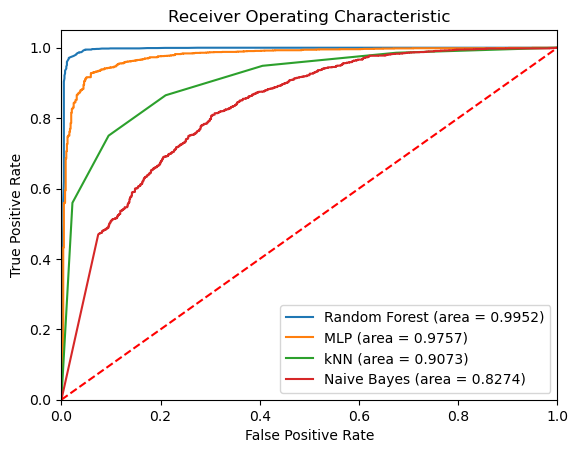

In [37]:
#predict probabilities for each classifier
y_pred_rf = rf.predict_proba(test_features_filtered.values)[:,1]
y_pred_mlp = mlp.predict_proba(test_features_filtered.values)[:,1]
y_pred_knn = knn.predict_proba(test_features_filtered.values)[:,1]
y_pred_nb = nb.predict_proba(test_features_filtered.values)[:,1]

#calculate ROC-AUC for each classifier
roc_auc_rf = metrics.roc_auc_score(y_test, y_pred_rf)
roc_auc_mlp = metrics.roc_auc_score(y_test, y_pred_mlp)
roc_auc_knn = metrics.roc_auc_score(y_test, y_pred_knn)
roc_auc_nb = metrics.roc_auc_score(y_test, y_pred_nb)

#Calculate ROC curves for each classifier
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test, y_pred_mlp)
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, y_pred_knn)
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test, y_pred_nb)

#plot ROC curves
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.4f)' % roc_auc_rf)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = %0.4f)' % roc_auc_mlp)
plt.plot(fpr_knn, tpr_knn, label='kNN (area = %0.4f)' % roc_auc_knn)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.4f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

# calculate confusion matrices
cm_rf = confusion_matrix(y_test, rf.predict(test_features_filtered.values))
cm_mlp = confusion_matrix(y_test, mlp.predict(test_features_filtered.values))
cm_knn = confusion_matrix(y_test, knn.predict(test_features_filtered.values))
cm_nb = confusion_matrix(y_test, nb.predict(test_features_filtered.values))

print("Confusion matrices:")
print("Random Forest")
print(cm_rf)
print("MLP")
print(cm_mlp)
print("KNN")
print(cm_knn)
print("Naive Bayes")
print(cm_nb)

#Calculate F1 score
f1_rf = metrics.f1_score(y_test, rf.predict(test_features_filtered.values))
f1_mlp = metrics.f1_score(y_test, mlp.predict(test_features_filtered.values))
f1_knn = metrics.f1_score(y_test, knn.predict(test_features_filtered.values))
f1_nb = metrics.f1_score(y_test, nb.predict(test_features_filtered.values))

print("F1 scores:")
print("Random Forest: ", f1_rf)
print("MLP: ", f1_mlp)
print("kNN: ", f1_knn)
print("Naive Bayes: ", f1_nb)


Confusion matrices:
Random Forest
[[ 755   54]
 [   8 2094]]
MLP
[[ 713   96]
 [  94 2008]]
KNN
[[ 639  170]
 [ 284 1818]]
Naive Bayes
[[ 717   92]
 [1001 1101]]
F1 scores:
Random Forest:  0.9854117647058823
MLP:  0.9548264384213029
kNN:  0.888997555012225
Naive Bayes:  0.6682852807283763
